In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *
from solvel0 import solvel0

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

from function_collections import msemse

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
X_pre = np.load("./IPI_output_files/X_pre_noise1e-1_denoised.npy")
y_pre = np.load("./IPI_output_files/y_pre_noise1e-1_denoised.npy")
u_pre, v_pre = y_pre[:, 0:1], y_pre[:, 1:2]
del y_pre
best_subsets_u = np.load('./IPI_output_files/u/best_subsets_denoised.npy', allow_pickle=True)
best_subsets_v = np.load('./IPI_output_files/v/best_subsets_denoised.npy', allow_pickle=True)

In [3]:
from UBIC import *

In [4]:
tau = 3; per = 75 # 85
scale = 1
# scale = np.log(len(u_pre))

post_means, b_bics, b_uns = baye_uncertainties(best_subsets_u, (X_pre, u_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets_u])
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(slopes, per)
while thres < 0:
    percentile = per + 5
    thres = np.percentile(slopes, min(99, percentile))
    if percentile >= 100: 
        break

d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)

# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets_u):
    com = len(efi)
    assert com == np.count_nonzero(post_means[:, k:k+1])
#     lower_bound = 2*log_like_value(predictions[:, k:k+1], u_pre)/np.log(len(u_pre))-com
    lower_bound = 2*log_like_value(predictions[:, k:k+1], u_pre)-np.log(len(u_pre))*com
    lower_bounds.append(lower_bound)
    
last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))
    
#     if (diff_com > 0 and imp < thres) or (diff_com < 0 and imp > thres):
#         break
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

last_lam = round(last_lam, 10)
last_lam_d_u = last_lam
last_ubic_d_u = last_ubic
last_bc_d_u = last_bc
uns_u = b_uns
last_lam, last_ubic, last_bc

0.13696923174845235
5 <---> 5 inf
5 <---> 5 inf


(1.8322798448,
 array([-195110.75586127, -201130.44586789, -216027.29134386,
        -249620.28077663, -271002.64944798, -313866.88943767,
        -313863.10278065, -313849.72887549, -313838.57957242,
        -313829.98022047, -313819.37377607, -313758.9904978 ]),
 5)

In [5]:
tau = 3; per = 75 # 85
scale = np.log(len(v_pre))
scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets_v, (X_pre, v_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets_v])
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(slopes, per)
while thres < 0:
    percentile = per + 5
    thres = np.percentile(slopes, min(99, percentile))
    if percentile >= 100: 
        break
        
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
        
# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets_v):
    com = len(efi)
    assert com == np.count_nonzero(post_means[:, k:k+1])
#     lower_bound = 2*log_like_value(predictions[:, k:k+1], v_pre)/np.log(len(v_pre))-com
    lower_bound = 2*log_like_value(predictions[:, k:k+1], v_pre)-np.log(len(v_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))
    
#     if (diff_com > 0 and imp < thres) or (diff_com < 0 and imp > thres):
#         break
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

last_lam = round(last_lam, 10)
last_lam_d_v = last_lam
last_ubic_d_v = last_ubic
last_bc_d_v = last_bc
uns_v = b_uns
last_lam, last_ubic, last_bc

0.10598674457151297
4 <---> 4 inf
4 <---> 7 1.465320735032407e-05


(3.6753610071,
 array([ 546956.8112994 , 1016785.12276304,  364245.06502511,
        -101756.40393391, -321132.39921461, -321015.85864907,
        -320843.60843649, -320727.65704477, -320044.37078613,
        -319425.7282828 , -319219.08943043, -316133.48461788]),
 4)

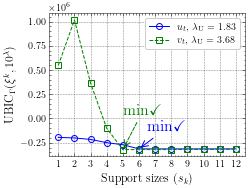

In [6]:
assert list(map(len, best_subsets_u)) == list(map(len, best_subsets_v))
complexities = list(map(len, best_subsets_u))
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot(complexities, last_ubic_d_u, 'o-', c='blue', markerfacecolor='none', label="$u_t,\, \lambda_{\\textrm{U}}=$ "+str(round(last_lam_d_u, 2)))
    ax.plot(complexities, last_ubic_d_v, 's--', c='green', markerfacecolor='none', label="$v_t,\, \lambda_{\\textrm{U}}=$ "+str(round(last_lam_d_v, 2)))
    ax.set_xticks(complexities)
    ax.set_ylabel("$\\textrm{UBIC}_{\\Gamma}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)

    plt.annotate('min$\checkmark$', fontsize=16, c='blue', 
             xy=(complexities[last_bc_d_u], last_ubic_d_u[last_bc_d_u]), 
             xytext=(complexities[last_bc_d_u]+0.5, last_ubic_d_u[last_bc_d_u]+1.75e5), 
             arrowprops={'arrowstyle': '->', 'linestyle':'-', 'color':'blue'})
    
    plt.annotate('min$\checkmark$', fontsize=16, c='green', 
             xy=(complexities[last_bc_d_v], last_ubic_d_v[last_bc_d_v]), 
             xytext=(complexities[last_bc_d_v], last_ubic_d_v[last_bc_d_v]+3.5e5), 
             arrowprops={'arrowstyle': '->', 'linestyle':'--', 'color':'green'})
    
    plt.legend()
    fig.savefig("../Figures/RD3D/rd3d_scale_ubics.pdf")
    plt.show()

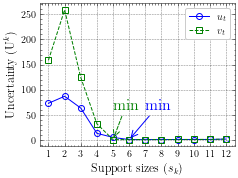

In [7]:
assert list(map(len, best_subsets_u)) == list(map(len, best_subsets_v))
complexities = list(map(len, best_subsets_u))
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot(complexities, uns_u, 'o-', c='blue', markerfacecolor='none', label="$u_t$")
    ax.plot(complexities, uns_v, 's--', c='green', markerfacecolor='none', label="$v_t$")
    ax.set_xticks(complexities)
    ax.set_ylabel("Uncertainty ($\\textrm{U}^{k}$)", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)

    plt.annotate('min', fontsize=16, c='blue', 
             xy=(complexities[np.argmin(uns_u)], uns_u[np.argmin(uns_u)]), 
             xytext=(complexities[np.argmin(uns_u)]+1, uns_u[np.argmin(uns_u)]+60), 
             arrowprops={'arrowstyle': '->', 'linestyle':'-', 'color':'blue'})
    
    plt.annotate('min', fontsize=16, c='green', 
             xy=(complexities[np.argmin(uns_v)], uns_v[np.argmin(uns_v)]), 
             xytext=(complexities[np.argmin(uns_v)], uns_v[np.argmin(uns_v)]+60), 
             arrowprops={'arrowstyle': '->', 'linestyle':'--', 'color':'green'})
    
    plt.legend()
#     fig.savefig("../Figures/RD3D/rd3d_uns.pdf")
    plt.show()

In [8]:
# tmp = np.zeros((len(best_subsets_u), X_pre.shape[-1]))
# for i in range(len(best_subsets_u)):
#     tmp[i:i+1, :][0, best_subsets_u[i]] = 1.0
# best_subsets_u = tmp.astype(np.float32)
# # best_subsets_u

In [9]:
# tmp = np.zeros((len(best_subsets_v), X_pre.shape[-1]))
# for i in range(len(best_subsets_v)):
#     tmp[i:i+1, :][0, best_subsets_v[i]] = 1.0
# best_subsets_v = tmp.astype(np.float32)
# # best_subsets_v

In [10]:
# pms_data = {"X_pre": X_pre, 
#             "u_pre": u_pre,
#             "v_pre": v_pre,
#             "best_subsets_u": best_subsets_u, 
#             "best_subsets_v": best_subsets_v}

# h5file(file_path="./IPI_output_files/PMS_data.h5", cdict=pms_data, mode='w')

# pms_data